In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from importkickdata import loadkickdata

# Function loads and cleans kicking data from profootballreference.com
kicks = loadkickdata('kickingdata.csv')
kicks.columns

Index(['Date', 'Tm', 'At', 'Opp', 'Result', 'Player', 'Dist', 'Good?', 'Blk?',
       'Home', 'PlayerID', 'Stadium', 'Dist_sq', 'Season'],
      dtype='object')

In [30]:
kicks = pd.read_csv('kickingdata.csv', header=0)

# Rename column containing an @ symbol if the kicking team is the away team.
kicks.rename(columns={'Unnamed: 3':'At'}, inplace=True)

# Delete index column in csv
del kicks['Rk']

# Create boolean column if kicking team is the home team
kicks['Home'] = (kicks['At'] != '@')

# Isolate unique player id
kicks['PlayerID'] = kicks['Player'].apply(lambda x: str.split(x, '\\')[1])

# Create variable for team whose stadium the game is played at
kicks['Stadium'] = kicks.apply(lambda x: [x['Opp'],x['Tm']][x['Home']], axis='columns')

# Reformat 'Good?' column to be a boolean
kicks['Good?'] = (kicks['Good?']=='Y')

# Reformat blocked kick column to be a boolean
kicks['Blk?'] = (kicks['Blk?']=='Y')

# Function to convert date from the given format (a string with the format mm/dd/yy) 
# to python date format.
def convert_date(x):
    x = x.split('/')
    return datetime.date(int('20'+x[2]), int(x[0]), int(x[1]))

# Reformat date column
kicks['Date'] = kicks['Date'].apply(convert_date)

# Create variable for distance squared
kicks['Dist_sq'] = kicks['Dist'].apply(lambda x: x**2)

# Create variable for season of kick
kicks['Season'] = kicks['Date'].apply(lambda x: x.year)

# Create month variable
kicks['Month'] = kicks['Date'].apply(lambda x: x.month)

# Add constant term for regression
kicks['Constant'] = 1

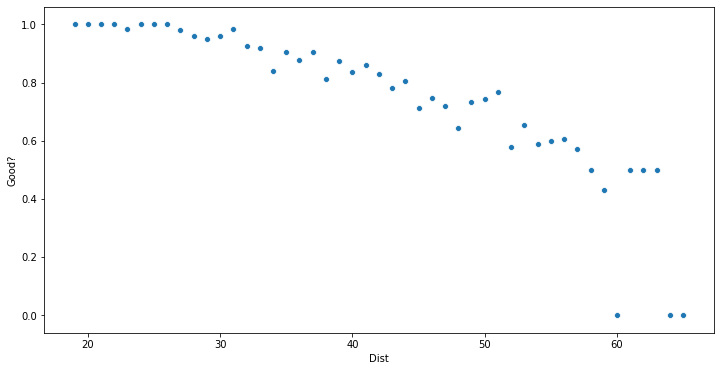

In [7]:
# Create scatter plot displaying success rate by distance of kick
bydistance = kicks.groupby(['Dist']).mean()

plt.figure(figsize=(12,6))
sns.scatterplot(bydistance.index, bydistance['Good?'])
plt.show()

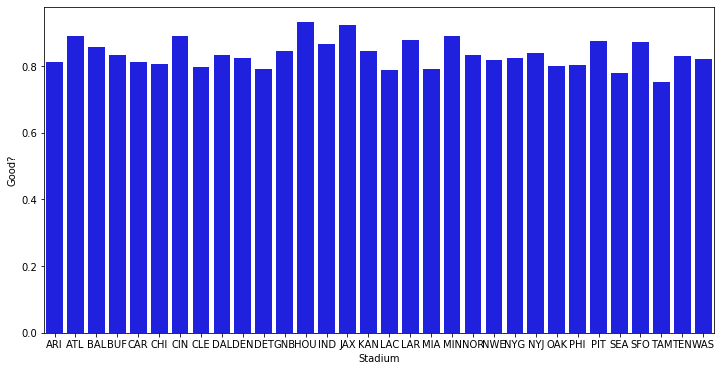

In [9]:
bystadium = kicks.groupby(['Stadium']).mean()

plt.figure(figsize=(12,6))
sns.barplot(bystadium.index, bystadium['Good?'], color='blue')
plt.show()

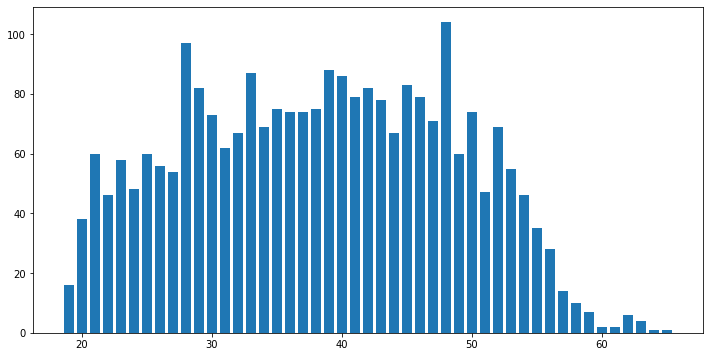

In [10]:
plt.figure(figsize=(12,6))
plt.bar(kicks['Dist'].value_counts().sort_index().index, kicks['Dist'].value_counts().sort_index())
plt.show()

In [11]:
kicks.columns

Index(['Date', 'Tm', 'At', 'Opp', 'Result', 'Player', 'Dist', 'Good?', 'Blk?',
       'Home', 'PlayerID', 'Stadium', 'Dist_sq', 'Season', 'Month'],
      dtype='object')

In [102]:
y = kicks['Good?']
X = kicks[['Dist', 'Dist_sq', 'Constant']]

probit_sq = sm.Probit(y, X)
probit_sq_res = probit_sq.fit()
probit_sq_me = probit_sq_res.get_margeff()
probit_sq_me.summary()

Optimization terminated successfully.
         Current function value: 0.379512
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                  Good?
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Dist          -0.0297      0.007     -4.340      0.000      -0.043      -0.016
Dist_sq        0.0002   8.07e-05      2.494      0.013    4.31e-05       0.000
==============================================================================
"""

In [46]:
X

,Dist,Dist_sq,Constant
0,39,1521,1
1,47,2209,1
2,42,1764,1
3,43,1849,1
4,47,2209,1
5,46,2116,1
6,54,2916,1
7,41,1681,1
8,43,1849,1
9,48,2304,1


In [113]:
kicks['Kick prob'] = probit_res.predict(kicks[['Dist', 'Constant']])

In [62]:
probit_sq_res.predict(([[0,0,1],[1,1,1],[10,100,1],[20,400,1], [30,900,1]]))

array([0.99999982, 0.99999962, 0.99991932, 0.996006  , 0.95756715])

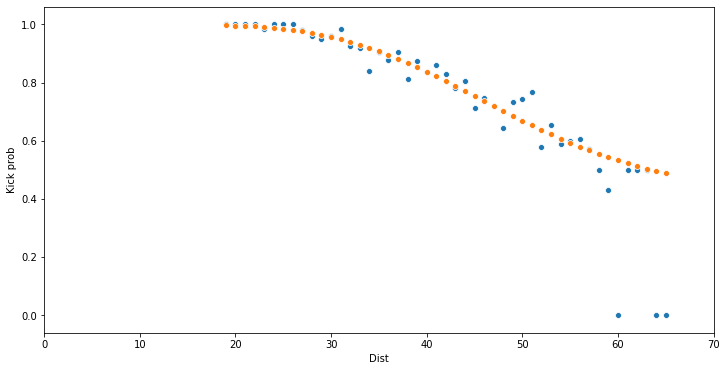

In [101]:
bydistance = kicks.groupby(['Dist']).mean()

plt.figure(figsize=(12,6))
sns.scatterplot(bydistance.index, bydistance['Good?'])
sns.scatterplot(bydistance.index, bydistance['Kick prob'])
plt.xlim([0,70])

plt.show()

Optimization terminated successfully.
         Current function value: 0.380810
         Iterations 6


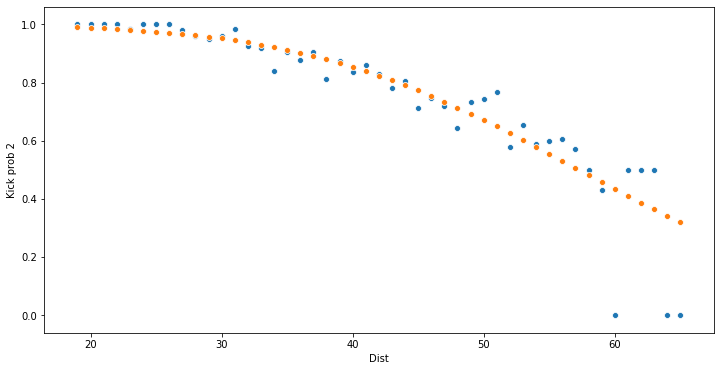

In [100]:
y = kicks['Good?']
X = kicks[['Dist','Constant']]

probit = sm.Probit(y, X)
probit_res = probit.fit()
probit_me = probit_res.get_margeff()
probit_me.summary()

kicks['Kick prob 2'] = probit_res.predict(kicks[['Dist', 'Constant']])

bydistance = kicks.groupby(['Dist']).mean()

plt.figure(figsize=(12,6))
sns.scatterplot(bydistance.index, bydistance['Good?'])
sns.scatterplot(bydistance.index, bydistance['Kick prob 2'])

plt.show()

In [143]:
probit_me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                  Good?
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Dist          -0.0128      0.001    -18.562      0.000      -0.014      -0.011
==============================================================================
"""

In [81]:
scatter_data = pd.DataFrame()
scatter_data['cons'] = 1
#for i in range(10):
    '''newrow = []
    newrow.append(i)
    newrow.append(i**2)
    newrow.append(1)
    newrow.append(probit_res.predict([i, 1])[0])
    newrow.append(probit_sq_res.predict([i, i**2, 1])[0])
    print(newrow)'''
    #scatter_data.append([[i],[i**2],[1],probit_res.predict([i, 1])[0],probit_sq_res.predict([i, i**2, 1])[0]])

scatter_data
    

IndentationError: unexpected indent (<ipython-input-81-1e00cdc96888>, line 4)

In [108]:
scatter_data = pd.DataFrame()
scatter_data['cons'] = [1]*100
scatter_data['yards'] = scatter_data.index
scatter_data['yards_sq'] = scatter_data['yards']**2
scatter_data['yards_cu'] = scatter_data['yards']**3
scatter_data['linear_predict'] = probit_res.predict(scatter_data[['yards', 'cons']])
scatter_data['sq_predict'] = probit_sq_res.predict(scatter_data[['yards', 'yards_sq', 'cons']])
scatter_data['cu_predict'] = probit_cu_res.predict(scatter_data[['yards', 'yards_sq', 'yards_cu', 'cons']])

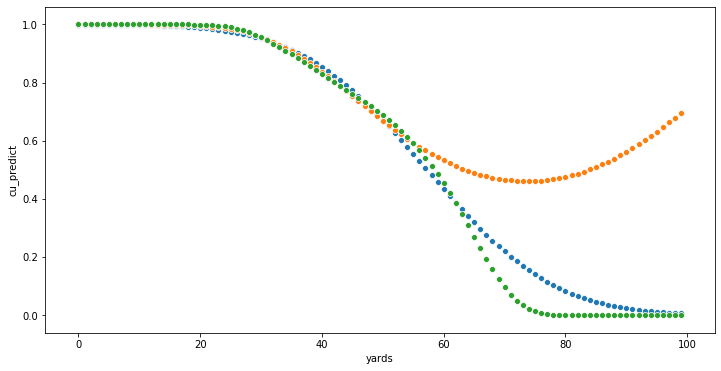

In [109]:
plt.figure(figsize=(12,6))
sns.scatterplot(scatter_data['yards'], scatter_data['linear_predict'])
sns.scatterplot(scatter_data['yards'], scatter_data['sq_predict'])
sns.scatterplot(scatter_data['yards'], scatter_data['cu_predict'])

plt.show()

In [92]:
kicks.columns

Index(['Date', 'Tm', 'At', 'Opp', 'Result', 'Player', 'Dist', 'Good?', 'Blk?',
       'Home', 'PlayerID', 'Stadium', 'Dist_sq', 'Season', 'Month', 'Constant',
       'Kick prob', 'Kick prob 2'],
      dtype='object')

Optimization terminated successfully.
         Current function value: 0.378691
         Iterations 8


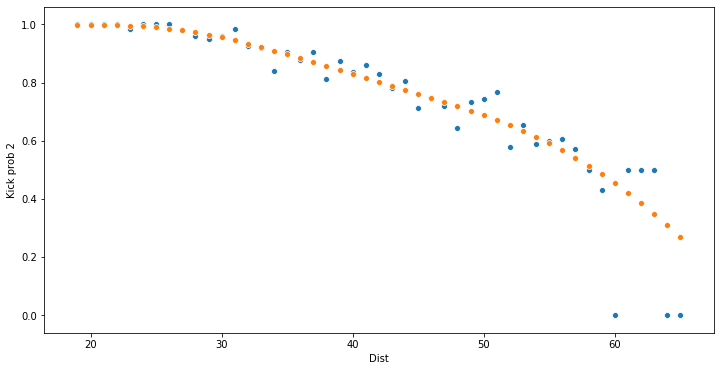

In [106]:
kicks['Dist_cu'] = kicks['Dist'].apply(lambda x: x**3)

y = kicks['Good?']
X = kicks[['Dist', 'Dist_sq', 'Dist_cu', 'Constant']]

probit_cu = sm.Probit(y, X)
probit_cu_res = probit_cu.fit()
probit_cu_me = probit_cu_res.get_margeff()
probit_cu_me.summary()

kicks['Kick prob 2'] = probit_cu_res.predict(kicks[['Dist', 'Dist_sq', 'Dist_cu', 'Constant']])

bydistance = kicks.groupby(['Dist']).mean()

plt.figure(figsize=(12,6))
sns.scatterplot(bydistance.index, bydistance['Good?'])
sns.scatterplot(bydistance.index, bydistance['Kick prob 2'])

plt.show()

In [114]:
playerstats = kicks.groupby(['PlayerID']).mean()
playerstats['Percent differential'] = playerstats['Good?'] - playerstats['Kick prob']
playerstats['Percent differential'].nlargest(10)

PlayerID
SeibAu00      0.113049
TuckJu00      0.098778
LambJo00      0.087378
GanoGr44      0.084703
ZuerGr00      0.053876
BadgMi00      0.053649
PratMa20      0.052258
bryanmat01    0.052245
gouldrob01    0.040863
LutzWi00      0.039163
Name: Percent differential, dtype: float64

In [115]:
playerstats17 = kicks[kicks.Season==2017].groupby(['PlayerID']).mean()
playerstats17['Percent differential'] = playerstats17['Good?'] - playerstats17['Kick prob']
playerstats17['Percent differential'].nlargest(10)

PlayerID
SturCa00      0.204342
ZuerGr00      0.121670
gouldrob01    0.116192
TuckJu00      0.114304
LambJo00      0.088611
GanoGr44      0.088088
HausSt00      0.082058
PratMa20      0.068515
bryanmat01    0.064133
GostSt20      0.057938
Name: Percent differential, dtype: float64

In [116]:
playerstats18 = kicks[kicks.Season==2018].groupby(['PlayerID']).mean()
playerstats18['Percent differential'] = playerstats18['Good?'] - playerstats18['Kick prob']
playerstats18['Percent differential'].nlargest(10)

PlayerID
TaveGi00      0.224587
nugenmik01    0.163363
bryanmat01    0.153685
RosaAl00      0.107309
MyerJa00      0.106569
HopkDu00      0.098668
BadgMi00      0.092495
gouldrob01    0.090696
LambJo00      0.088900
LutzWi00      0.084175
Name: Percent differential, dtype: float64

In [117]:
# Exclude December
playerstats18_nodec = kicks[((kicks.Season==2018) & (kicks.Month != 12))].groupby(['PlayerID']).mean()
playerstats18_nodec['Percent differential'] = playerstats18_nodec['Good?'] - playerstats18_nodec['Kick prob']
playerstats18_nodec['Percent differential'].nlargest(10)

PlayerID
TaveGi00      0.224587
bryanmat01    0.213395
nugenmik01    0.163363
HausSt00      0.136620
MyerJa00      0.125190
BadgMi00      0.117537
LutzWi00      0.107978
LambJo00      0.090026
gouldrob01    0.089246
SandJa00      0.085181
Name: Percent differential, dtype: float64

In [130]:
playerstats19 = kicks[kicks.Season==2019].groupby(['PlayerID']).mean()
playerstats19['Percent differential'] = playerstats19['Good?'] - playerstats19['Kick prob']
playerstats19['Percent differential'].nsmallest(10)

PlayerID
VedvKa00     -0.772776
SuccRy44     -0.709776
SantCa01     -0.315530
nugenmik01   -0.309388
gouldrob01   -0.198277
HausSt00     -0.133474
bryanmat01   -0.133031
McLaCh00     -0.130628
RosaAl00     -0.125277
vinatada01   -0.095526
Name: Percent differential, dtype: float64

In [118]:
shaus = kicks[kicks['PlayerID'] == 'HausSt00']
shaus.groupby(['Season', 'Month']).mean().loc[:,['Dist', 'Good?', 'Kick prob']]

Dist     Good?  Kick prob
Season Month                                
2017   9      45.833333  0.833333   0.724116
       10     38.250000  0.916667   0.829066
       11     46.333333  0.833333   0.722414
       12     36.888889  0.888889   0.851567
2018   9      41.833333  0.833333   0.801484
       10     41.857143  1.000000   0.788655
       11     37.000000  1.000000   0.836992
       12     40.636364  0.545455   0.814077
2019   9      46.500000  0.666667   0.722645
       10     45.000000  0.750000   0.762645
       11     43.000000  0.333333   0.782904

In [119]:
shaus.groupby(['Season']).count()

,Date,Tm,At,Opp,Result,Player,Dist,Good?,Blk?,Home,PlayerID,Stadium,Dist_sq,Month,Constant,Kick prob,Kick prob 2,Dist_cu
Season,,,,,,,,,,,,,,,,,,
2017,33,33,19,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
2018,28,28,14,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
2019,13,13,3,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


In [120]:
shaus19 = shaus[shaus.Season==2019]

In [257]:
c = .75
kicksim = pd.DataFrame(np.random.choice([0,1], p=[c,1-c], size=20))
c = .8
#kicksim = pd.concat([kicksim, pd.Series(np.random.choice([0,1], p=[c,1-c], size=20))])
kicksim.assign(new = pd.Series(np.random.choice([0,1], p=[c,1-c], size=20)))

print()

In [121]:
kicksim = pd.DataFrame()
probs = list(shaus19['Kick prob'])
for i in range(13):
    col_name = 'kick ' + str(i+1)
    kicksim[col_name] = pd.Series(np.random.choice([1,0], p=[probs[i],1-probs[i]], size=1000))

In [122]:
kicksim.describe()

,kick 1,kick 2,kick 3,kick 4,kick 5,kick 6,kick 7,kick 8,kick 9,kick 10,kick 11,kick 12,kick 13
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.926000,0.580000,0.83700,0.614000,0.875000,0.760000,0.809000,0.69300,0.740000,0.380000,0.790000,0.925000,0.804000
std,0.261902,0.493805,0.36955,0.487074,0.330884,0.427297,0.393286,0.46148,0.438854,0.485629,0.407512,0.263523,0.397167
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.00000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [123]:
probs

[0.922039987399988,
 0.6026009191364057,
 0.8240716910943428,
 0.6026009191364057,
 0.8673538188912888,
 0.7727756227115052,
 0.8078504444313838,
 0.692887575816421,
 0.7539671978520093,
 0.38635171311330313,
 0.7727756227115052,
 0.922039987399988,
 0.8078504444313838]

In [124]:
sum(shaus19['Good?'])

8

In [125]:
kicksim['Kicks made'] = 0

for k in range(kicksim.shape[0]):
    kicksim.loc[k, 'Kicks made'] = sum(kicksim.iloc[k,:])



#sum(kicksim.iloc[1,:])

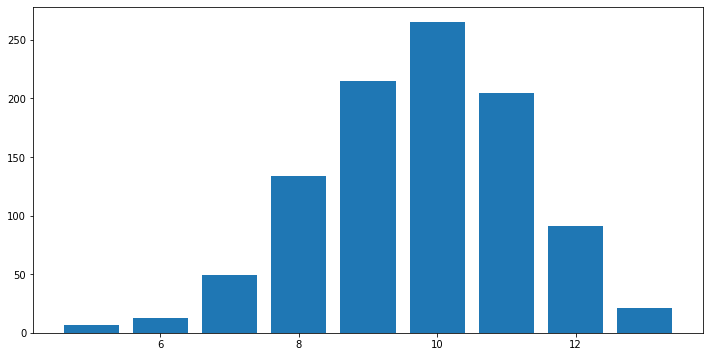

In [128]:
plt.figure(figsize=(12,6))
plt.bar(kicksim['Kicks made'].value_counts().index, kicksim['Kicks made'].value_counts())
plt.show()

In [144]:
sum(kicksim['Kicks made'] <= 8)

203

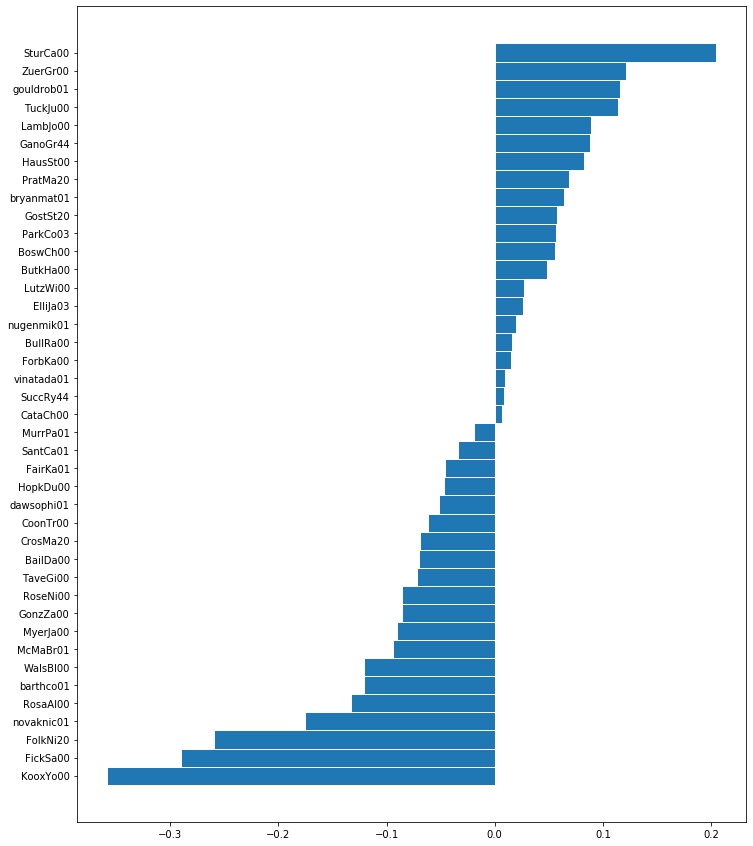

In [141]:
playerstats17 = playerstats17.sort_values(by=['Percent differential'])
plt.figure(figsize=(12,15))
plt.barh(playerstats17.index,playerstats17['Percent differential'], height=1, edgecolor='white')
plt.show()